In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from typing import Literal
from collections.abc import Callable

%matplotlib inline

In [2]:
###moduleDir = 'MACHINE LEARNING'
outDir = os.path.join('output')

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
rng = np.random.default_rng(seed = RANDOM_STATE)

NOISE = 0.2
EPOCHS = 20001
N_SAMPLES = 1280
ALPHA = 0.1
NUM_HIDDEN = 4

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large',
          'savefig.dpi': 150,
          'image.cmap': 'jet',
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 2,
          'legend.numpoints' : 1
         }
CMAP = 'coolwarm'
plt.rcParams.update(params);
plt.set_cmap(CMAP);
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

TEST_SIZE=0.2

<Figure size 1500x600 with 0 Axes>

In [3]:
def fn_plot_decision_boundary(pred_func:Callable[[], np.float64],
                             X_tr : np.ndarray,   # training features
                             X_ts : np.ndarray,    # testing features
                             y_tr : np.ndarray,    # training labels
                             y_ts : np.ndarray    # testing labels
                             ):

    # set Min & Max values & give it some padding
    x_min, x_max = X_tr[:,0].min() - .05, X_tr[:,0].max() + .05
    y_min, y_max = X_tr[:,1].min() - .05, X_tr[:,1].max() + .05
    
    # grid size for mesh grid
    h = 0.01

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))

    Z = pred_func(np.c_[xx.ravel(),yy.ravel()])
    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    ax = fig.add_axes(111)
    
    ax.contourf(xx, yy,Z, cmap = CMAP)  

    ax.scatter(X_tr[:,0], X_tr[:,1], c=y_tr,
              s=30, edgecolor='k', cmap=plt.cm.coolwarm)  

    ax.scatter(X_ts[:,0], X_ts[:,1], c=y_ts,
              s=100, marker='*', edgecolor='k', cmap=plt.cm.inferno)  
    

In [4]:
X, y = datasets.make_moons(n_samples = N_SAMPLES,
                           shuffle = True, 
                           noise = NOISE,
                            random_state=RANDOM_STATE)
X[:5],y[:5]

(array([[ 2.27884737,  0.26168543],
        [-0.23790006,  0.86719265],
        [-0.00391944, -0.28678754],
        [ 2.04347758,  0.63303644],
        [ 0.09689466, -0.25552249]]),
 array([1, 0, 1, 1, 1], dtype=int64))

In [5]:
data_df = pd.DataFrame(X, columns=['A','B'])

data_df['target'] = y

data_df.head()

,A,B,target
0,2.278847,0.261685,1
1,-0.237900,0.867193,0
2,-0.003919,-0.286788,1
3,2.043478,0.633036,1
4,0.096895,-0.255522,1


In [6]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280 entries, 0 to 1279
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       1280 non-null   float64
 1   B       1280 non-null   float64
 2   target  1280 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 30.1 KB


In [7]:
data_df.describe()

,A,B,target
count,1280.000000,1280.000000,1280.000000
mean,0.506595,0.247313,0.500000
std,0.891242,0.528813,0.500195
min,-1.468541,-0.976250,0.000000
25%,-0.120409,-0.193289,0.000000
50%,0.503414,0.233604,0.500000
75%,1.131021,0.670022,1.000000
max,2.432350,1.472694,1.000000


In [8]:
data_df.isnull().sum()

A         0
B         0
target    0
dtype: int64

## Different way of plotting

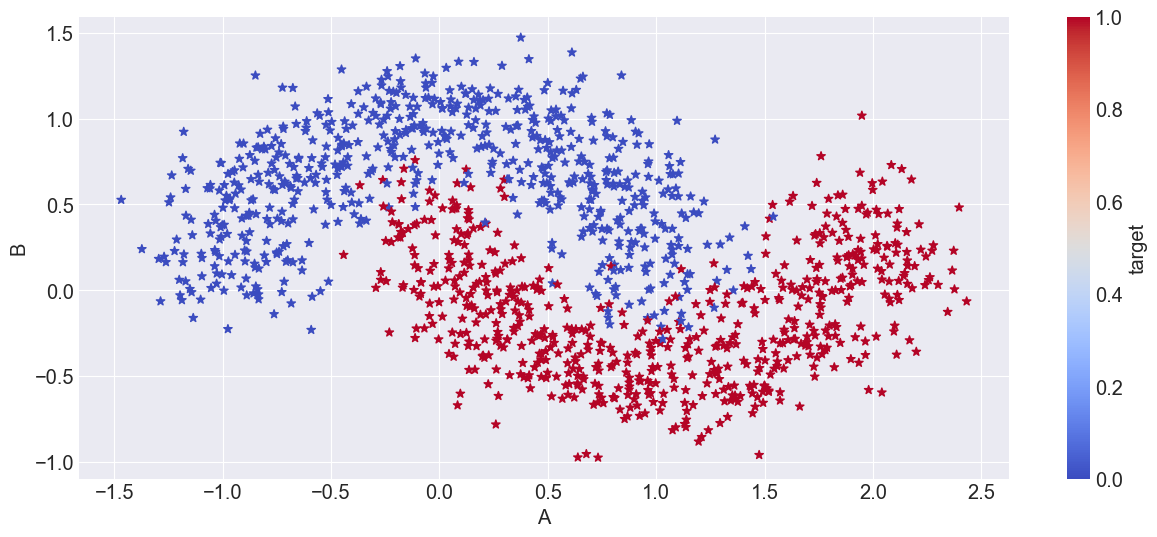

In [9]:
data_df.plot.scatter('A','B',
                    s = 40,
                    marker = '*',
                    c = 'target',
                    cmap = CMAP);

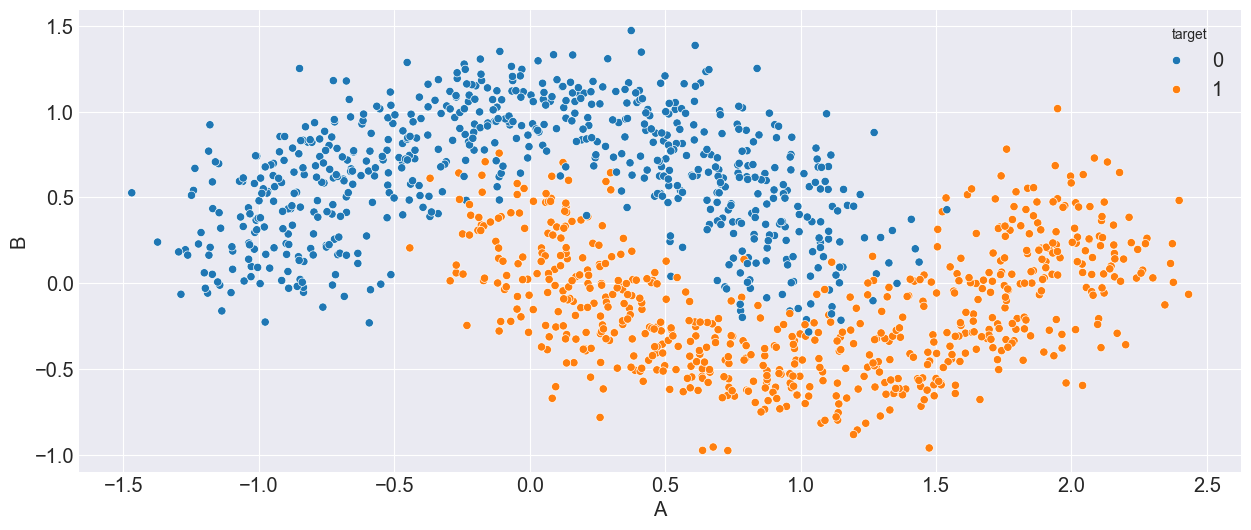

In [10]:
ax = sns.scatterplot(x = 'A',y='B',data = data_df,hue = 'target');

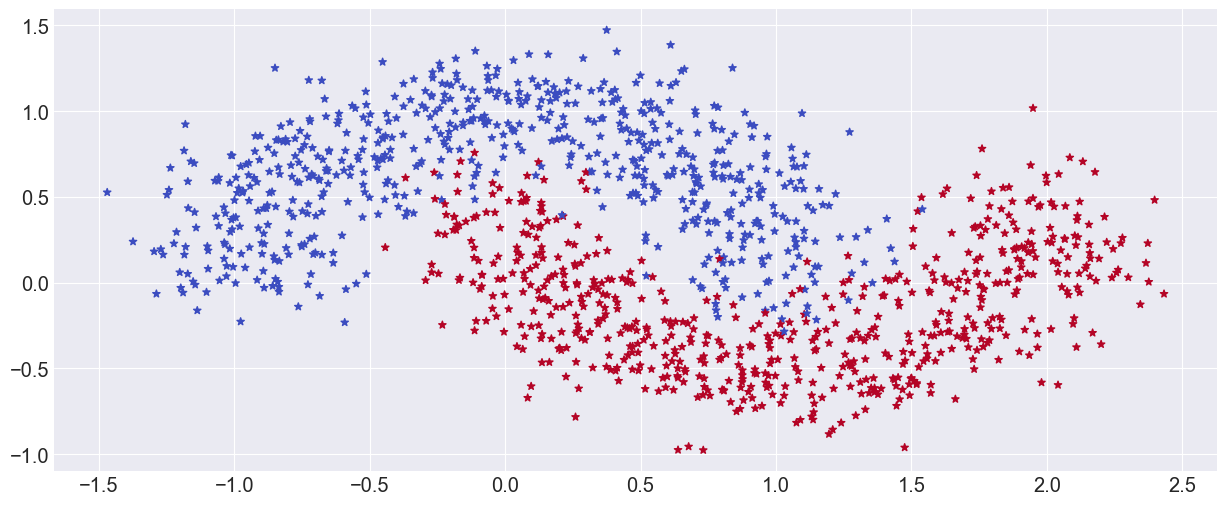

In [11]:
plt.scatter(X[:,0],X[:,1],s = 30,c= y,marker = '*',cmap=CMAP);

In [12]:
X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                test_size = TEST_SIZE,
                                                stratify = y,
                                                random_state = RANDOM_STATE)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1024, 2), (256, 2), (1024,), (256,))

In [13]:
# if you really want to save on space, convert to float32
X_train = X_train.astype(np.float32)

X_test = X_test.astype(np.float32)

y_train = y_train.astype(np.float32)

y_test = y_test.astype(np.float32)


In [14]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

In [15]:
def fn_sigmoid(z:np.ndarray) -> np.ndarray:
    '''
    Args:
        z = a matrix of z values of shape (m, n_output)
    return:
        a matrix containing sigmoid values of z
    '''
    
    return 1/ (1 + np.exp (-z))

In [16]:
def fn_tanh(z: np.ndarray) -> np.ndarray: #z:array,aggregated values
    
     return np.tanh(z)  # returns Activation for each z
    
def fn_tanh_prime(a:np.ndarray) -> np.ndarray:  #a:array,aggregated values

    return 1.0 - np.tanh(a)**2   # derivative for each a

In [17]:
fn_tanh(np.asarray([[-1, 0.,1.],[-np.inf,0.,np.inf]]))


array([[-0.76159416,  0.        ,  0.76159416],
       [-1.        ,  0.        ,  1.        ]])

In [18]:
np.tanh(0.5)

0.46211715726000974

In [19]:
(1 - np.power(np.tanh(0.5),2))

0.7864477329659274

In [20]:
fn_tanh_prime(0.5)

0.7864477329659274

In [21]:
(1 - np.power(fn_tanh_prime(0.5),2))

0.3814999633127534

In [22]:
def predict (model : dict , X:np.ndarray) -> Literal:

    W1,b1,W2,b2 = model['W1'],model['b1'],model['W2'],model['b2']
    
    z1 = X.dot(W1) + b1    #aggregation
    a1 = fn_tanh(z1)       # Activation

    # layer2
    z2 = a1.dot(W2) + b2
    a2 = fn_sigmoid(z2)

    return a2 >= 0.5

    

In [23]:
def calculate_loss (model : dict , X:np.ndarray,y:np.ndarray) -> np.float64:      # model : dict object , X: feature matrix,y : labels array

    W1,b1,W2,b2 = model['W1'],model['b1'],model['W2'],model['b2']
    
    m = X.shape[0]
    
    z1 = X.dot(W1) + b1    #aggregation
    a1 = fn_tanh(z1)       # Activation

    # layer2
    z2 = a1.dot(W2) + b2
    a2 = fn_sigmoid(z2)

    data_loss = -(y* np.log(a2)).sum()
    
    return 1./m * data_loss


In [24]:
def build_model(nn_hdim : np.int64,  # number of nodes in hidden layer
               X : np.ndarray,       # training feature
               y : np.ndarray,       # training targets
               epochs : np.int64 = EPOCHS, # no of passes through training data for gradient descent
                alpha : np.float64 = ALPHA) -> dict:  # learning rate
    # returns ->  model : Dictionary object containing weights and biases

    W1 = np.random.rand(nn_input_dim,nn_hdim) / np.sqrt(nn_input_dim)
    W2 = np.random.rand(nn_hdim,nn_output_dim) / np.sqrt(nn_hdim)

    b1 = np.zeros((1,nn_hdim))
    b2 = np.zeros((1,nn_output_dim))

    curr_loss = 0

    loss = []
    epoch = []

    for i in range(0,epochs): # loop for number of epochs

        ### Forward Propogation
        
        #layer 1
        z1 = X.dot(W1) + b1    #aggregation
        a1 = fn_tanh(z1)       # Activation

        # layer2
        z2 = a1.dot(W2) + b2
        a2 = fn_sigmoid(z2)

        ### Back Propogation

        # Layer 2

        dz2= a2-y

        dW2 = (a1.T).dot(dz2)
        assert (W2.shape == dW2.shape), 'shape of W2 {} and shape of dW2 {}'.format(W2.shape, dW2.shape)

        db2 = np.sum(dz2, axis = 0, keepdims =True)
        assert (b2.shape == db2.shape), 'shape of b2 {} and shape of db2 {}'.format(b2.shape, db2.shape)

        da1 = dz2.dot(W2.T)
        assert (a1.shape == da1.shape), 'shape of a1 {} and shape of da1 {}'.format(a1.shape, da1.shape)

        dz1 = da1 * fn_tanh_prime(z1)
        assert (z1.shape == dz1.shape), 'shape of z1 {} and shape of dz1 {}'.format(z1.shape, dz1.shape)

        dW1 = (X.T).dot(dz1)
        assert (W1.shape == dW1.shape), 'shape of W1 {} and shape of dW1 {}'.format(W1.shape, dW1.shape)

        db1 = np.sum(dz1, axis = 0, keepdims =True)
        assert (b1.shape == db1.shape), 'shape of b1 {} and shape of db1 {}'.format(b1.shape, db1.shape)


        ############################
        ##### Gradient updates  ####
        ############################
        W1 += -alpha *dW1 / num_examples
        W2 += -alpha *dW2 / num_examples
        b1 += -alpha *db1 / num_examples
        b2 += -alpha *db2 / num_examples
    
        model = {'W1': W1,'b1':b1,'W2':W2,'b2':b2}  # store model in dict object.

        if i%100 == 0:            # for every nth epoch calculate loss for future plotting
            curr_loss = calculate_loss(model,X,y)
            loss.append(curr_loss)
            epoch.append(i)
            
        if i%1000 == 0:          # print loss every nth epoch
            print('loss after {} epochs : {}'.format(i,curr_loss))
            
    loss_hist['epoch'] = epoch
    loss_hist['loss'] = loss

    return model    

In [25]:
num_examples, nn_input_dim = X_train.shape #training set size(rows and cols)
nn_output_dim = 1  # output layer dimensionality

loss_hist = {}   # lists to facilitate plotting

In [26]:
num_examples, nn_input_dim

(1024, 2)

In [27]:
y_train = y_train.reshape(-1,1) 
y_train.shape

(1024, 1)

In [28]:
# Build a model
model = build_model(NUM_HIDDEN, X_train, y_train,
                   epochs = EPOCHS,
                   alpha=ALPHA)

loss after 0 epochs : 0.3593134889936863
loss after 1000 epochs : 0.13906953490209822
loss after 2000 epochs : 0.09559412152133821
loss after 3000 epochs : 0.07650527390397746
loss after 4000 epochs : 0.06659678458770177
loss after 5000 epochs : 0.05402625722695499
loss after 6000 epochs : 0.04908965113037783
loss after 7000 epochs : 0.04758285428978163
loss after 8000 epochs : 0.04691543027086709
loss after 9000 epochs : 0.04652058720870261
loss after 10000 epochs : 0.046238446740493475
loss after 11000 epochs : 0.04601653986297696
loss after 12000 epochs : 0.04583596896738478
loss after 13000 epochs : 0.045688719537594624
loss after 14000 epochs : 0.04556988803243662
loss after 15000 epochs : 0.045475131235731193
loss after 16000 epochs : 0.04540013079294998
loss after 17000 epochs : 0.045340758940574835
loss after 18000 epochs : 0.04529335229067029
loss after 19000 epochs : 0.04525487261987641
loss after 20000 epochs : 0.045222929301096455


### Prediction

In [29]:
model

{'W1': array([[ 2.23732335,  0.36104053,  2.73510001,  2.76004868],
        [-0.67752751, -0.09250819,  1.11071842, -0.54520727]]),
 'b1': array([[-2.38901961,  0.05935596,  0.1928546 ,  2.75953053]]),
 'W2': array([[ 6.11406756],
        [ 2.62092906],
        [-6.45386563],
        [ 6.17855458]]),
 'b2': array([[0.16911029]])}

In [30]:
y_pred  = predict(model,X_train)
print('Accuracy score on Train Data:', accuracy_score(y_train, y_pred))


Accuracy score on Train Data: 0.9619140625


In [31]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       512
         1.0       0.96      0.96      0.96       512

    accuracy                           0.96      1024
   macro avg       0.96      0.96      0.96      1024
weighted avg       0.96      0.96      0.96      1024



In [32]:
y_pred  = predict(model,X_test)
print('Accuracy score on Train Data:', accuracy_score(y_test, y_pred))


Accuracy score on Train Data: 0.98828125


In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       128
         1.0       1.00      0.98      0.99       128

    accuracy                           0.99       256
   macro avg       0.99      0.99      0.99       256
weighted avg       0.99      0.99      0.99       256



Text(0.5, 1.0, 'Decision boundary')

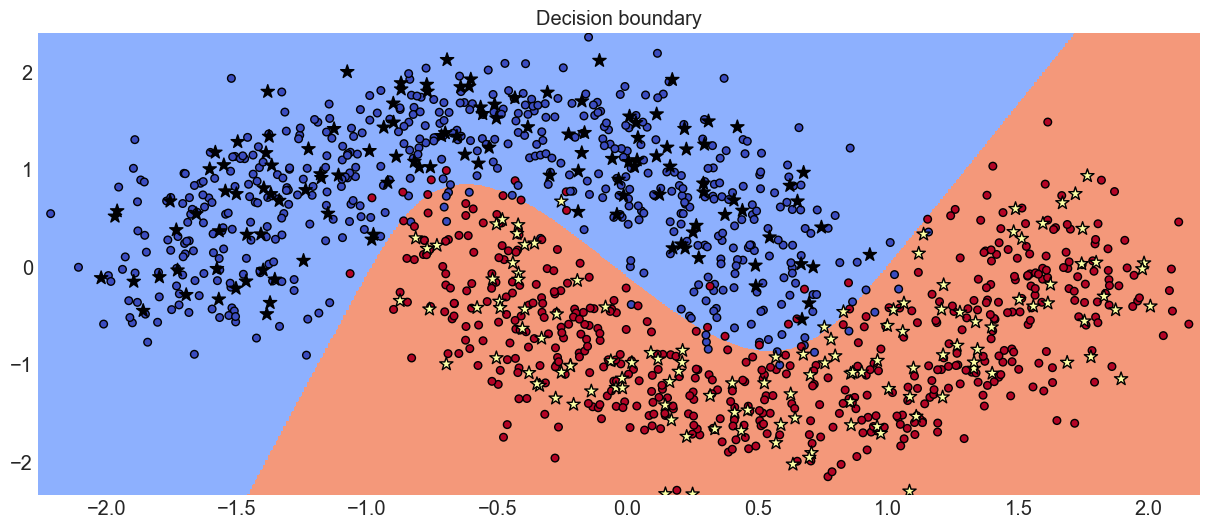

In [34]:
loss_df = pd.DataFrame(loss_hist)

fn_plot_decision_boundary(lambda x: predict(model, x), X_train,X_test, y_train,y_test)

plt.title("Decision boundary")

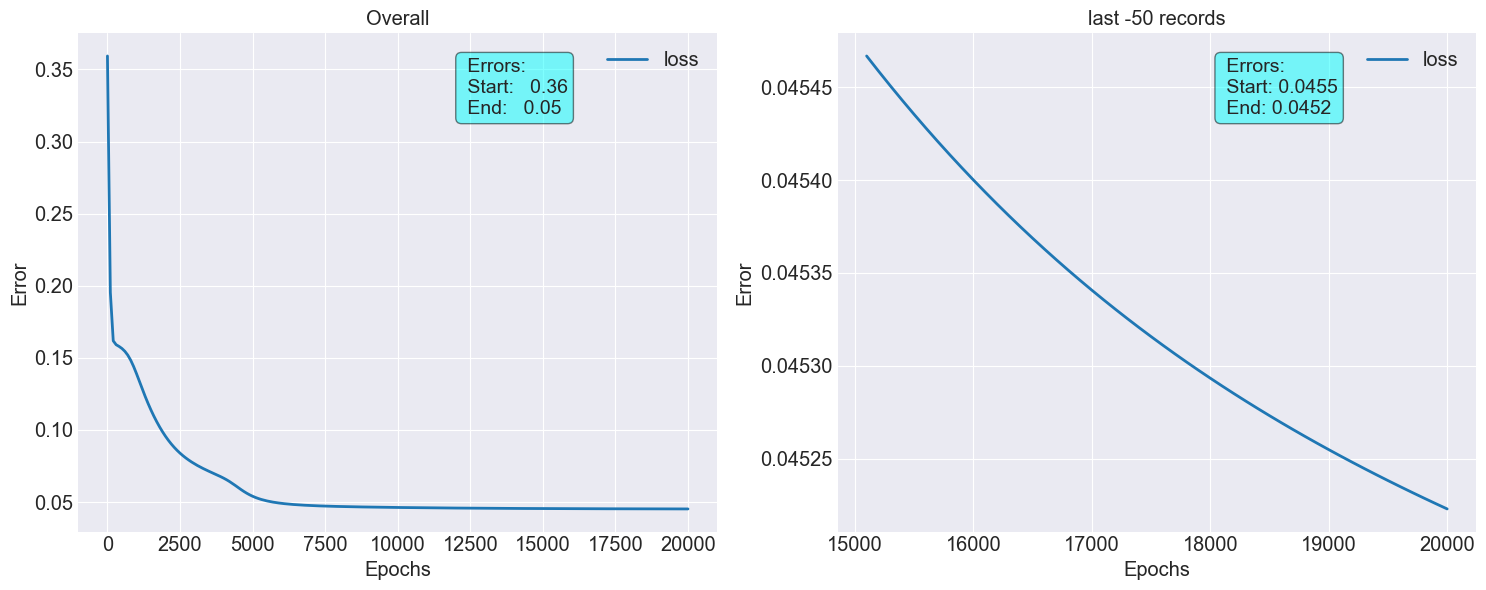

In [35]:
fig, axes = plt.subplots(1,2,figsize = (15,6))

l_range = 50

ax = axes [0]

loss_df.plot(x = 'epoch', y = 'loss', ax = ax)

txtstr = " Errors: \n Start:{:7.2f}\n End:{:7.2f}".format(loss_df.iloc[0]['loss'], loss_df.iloc[-1]['loss'])

props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)

ax.text(0.6,0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Overall')

ax = axes [1]

loss_df[-l_range:].plot(x = 'epoch', y = 'loss', ax = ax)

txtstr = " Errors: \n Start:{:7.4f}\n End:{:7.4f}".format(loss_df.iloc[-l_range]['loss'], loss_df.iloc[-1]['loss'])

ax.text(0.6,0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('last {} records'.format(-l_range))
#plt.grid()
plt.tight_layout()

In [36]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[128,   0],
       [  3, 125]], dtype=int64)

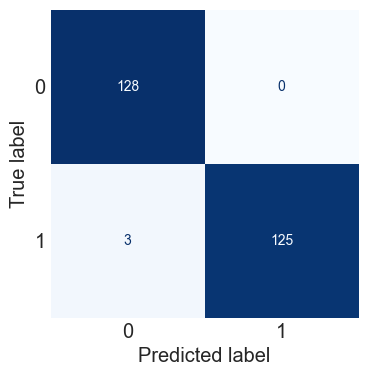

In [37]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[0,1])

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax=ax, cmap = 'Blues', colorbar=False)
plt.grid()
plt.show();